# Graph exploration

In [22]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx

Data_path = 'Data/'

Load the nodes attributes DataFrame

In [23]:
features_df = pd.read_csv(Data_path+'features.csv', index_col=0)
labels_df = pd.read_csv(Data_path+'labels.csv', index_col=0).drop(columns=['title'])
#nodes_attributes_df = pd.concat([features_df, labels_df], axis=1)

In [24]:
df = pd.read_csv(Data_path+'merged_data.csv', index_col=0)

In [25]:
nodes_attributes_df = df[['id', 'title','genres', 'overview', 'budget', 'revenue', 'popularity', 'runtime', 'vote_average', \
                                          'vote_count', 'Oscars', 'Nominations_Oscars', 'GoldenGlobes', 'Nominations_GoldenGlobes']]

Load the Adjacency matrix

In [150]:
with open(Data_path+'Adjacency_matrix05.pickle', 'rb') as src:
    A = pickle.load(src)
    print(f'>>> Loading Adjacency matrix matrix with shape {A.shape}')

>>> Loading Adjacency matrix matrix with shape (4802, 4802)


In [151]:
# checking that there is the good amount of rows (should equals number of node)
print(f'There are {A.shape[0]} nodes and {nodes_attributes_df.shape[0]} attributes rows.')

There are 4802 nodes and 4802 attributes rows.


Build a networkX graph from the adjacency matrix

In [152]:
def graph_summary(G, display=True, return_GC=False):
    """
    Display properties of the given nx.Graph
    ------
    Input 
        |---- G : nx.Graph
    Output 
        |---- None
    """
    # get the giant component:
    G_large = max(nx.connected_component_subgraphs(G), key=len)
    
    G_props = {}
    G_props['n_edges'] = G.number_of_edges()
    G_props['n_nodes'] = G.number_of_nodes()
    G_props['n_connect_comp'] = nx.number_connected_components(G)
    G_props['Giant_component_size'] = G_large.number_of_nodes()
    G_props['avg_degree'] = 2*G_props['n_edges'] /G_props['n_nodes']
    #G_props['GC_diameter'] = nx.diameter(G_large) 
    G_props['avg_cluster_coef'] = nx.average_clustering(G)
    
    if display:
        print('>>> Network Summary:')
        for prop_name, prop_value in G_props.items():
            print(f'\t |---- {prop_name} : {prop_value}')

In [178]:
# prune the adjacency matrix --> remove poorly nimilar connection
G=nx.from_numpy_matrix(np.where(A < 0.02, 0, A))
graph_summary(G)

>>> Network Summary:
	 |---- n_edges : 200519
	 |---- n_nodes : 4802
	 |---- n_connect_comp : 83
	 |---- Giant_component_size : 4719
	 |---- avg_degree : 83.51478550603915
	 |---- avg_cluster_coef : 0.14721253311762525


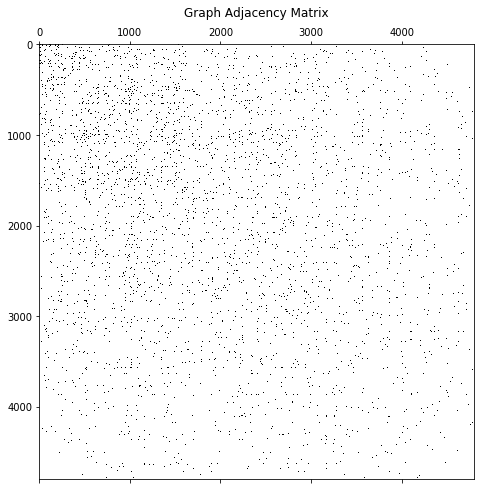

In [179]:
# spy on A
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('Graph Adjacency Matrix')
ax.spy(np.where(A < 0.02, 0, A))
plt.show()

In [180]:
matplotlib.rcParams['text.usetex'] = True

//anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5680: RuntimeWarning: divide by zero encountered in power
  return a*x**(a-1.0)


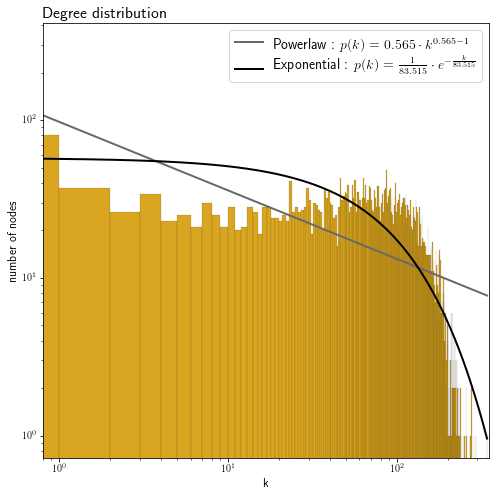

In [181]:
# Degree distribution
degrees = dict(G.degree()).values()

k = np.linspace(np.min(list(degrees)), np.max(list(degrees)), len(list(degrees)))

fig, ax = plt.subplots(1,1,figsize=(8,8))
hist = ax.hist(degrees, color='goldenrod', bins=np.max(list(degrees)), linewidth=0.1, edgecolor='black')
ax.set_title('Degree distribution', loc='left', fontsize=16)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('number of nodes', fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')

# fit power law
a, m, s = stats.powerlaw.fit(list(degrees)) # get estimates of distribution parameters
pdf_g = stats.powerlaw.pdf(k, a, scale=s)
ax.plot(k, pdf_g * len(list(degrees)), label=r"Powerlaw : $p(k) = {0:.3f} \cdot k^{{{0:.3f}-1}}$".format(a), \
            linewidth=2, color='dimgray')

# fit exponential 
m, s = stats.expon.fit(list(degrees)) # get estimates of distribution parameters
pdf_g = stats.expon.pdf(k, scale=s)
ax.plot(k, pdf_g * len(list(degrees)), label=r"Exponential : $p(k) = \frac{{1}}{{{0:.3f}}}  \cdot e^{{- \frac{{k}}{{{{{0:.3f}}}}}}}$".format(s), \
            linewidth=2, color='black', linestyle='-')

ax.set_xlim([0.8,np.max(list(degrees))+10])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', fontsize=14)

plt.show()

In [182]:
eigenvalues = nx.linalg.spectrum.normalized_laplacian_spectrum(G)

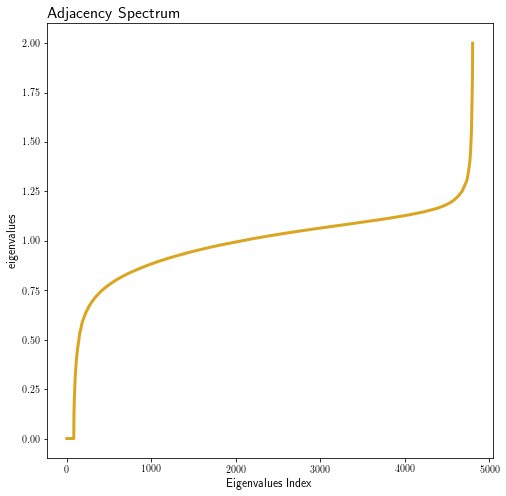

In [183]:
# Spectrum 
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(eigenvalues, color='goldenrod', linewidth=3)
ax.set_title('Adjacency Spectrum', loc='left', fontsize=16)
ax.set_xlabel('Eigenvalues Index', fontsize=12)
ax.set_ylabel('eigenvalues', fontsize=12)

plt.show()

## Graph Type 

In [ ]:
# --> check if power law (scale free)
# --> check if small world properties

## Explore the nodes attributes

Add the node attributes

In [164]:
nx.set_node_attributes(G, dict(nodes_attributes_df.transpose()))

In [165]:
# save in gexf
nx.write_gexf(G, 'networks/network_05_005.gexf')

Get the (normalized ?!) laplacian matrix. The smoothness of a signal $f$ on the graph is assessed by $f^TLf$. If the value is low the signal is rather smooth.

In [166]:
import pygsp as gsp

In [167]:
# make a pygsp graph from the networkx one
G_sp = gsp.graphs.Graph(nx.adjacency_matrix(G), lap_type='normalized')

//anaconda3/lib/python3.7/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [168]:
#L = nx.linalg.laplacian_matrix(G)

In [169]:
def get_quadratic_form(L, f):
    """
    get the Laplacian (L) Quatratic form of a signal (f). 
    INPUT
        |---- L [numpy array] the Laplacian of a graph of dimension N_node x N_node
        |---- f [numpy array] the signal on the graph of dimension N_node x 1
    OUTPUT 
        |---- qf [float] the value of f^T x L x f
    """
    return float(f.transpose() @ L @ f)

def signal_GFT(G, s, ax=None, **kwargs):
    """
    compute and plot the GFT of the passed signal s.
    INPUT
        |---- G [pygsp graph] 
        |---- s [numpy array] the signal on the graph of dimension N_node x 1
        |---- ax [matplotlib.Axes] the ax on which to plot the GFT
    OUTPUT 
        |---- s_hat [numpy array] the signal in the fourier domain
    """
    # compute the fourier basis (only performed if not already computed)
    G.compute_fourier_basis()
    
    # get GFT of signal
    s_hat = G.gft(s)
    # plot in ax
    if not ax is None:
        ax.plot(G.e, np.abs(s_hat),**kwargs)
    
    return s_hat

2019-12-17 23:11:24,720:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4802 x 4802) may take some time.


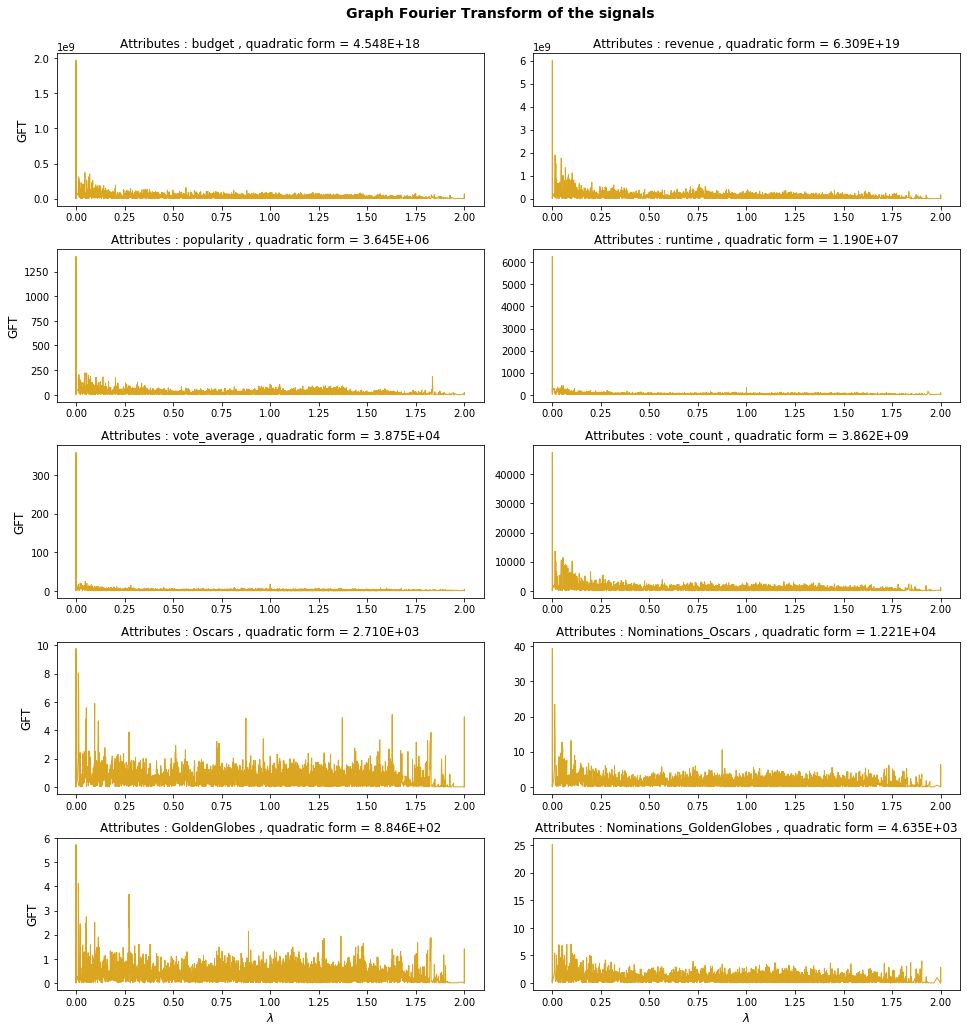

In [170]:
matplotlib.rcParams['text.usetex'] = False
attributes = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count', \
                     'Oscars', 'Nominations_Oscars', 'GoldenGlobes', 'Nominations_GoldenGlobes']

fig, axs = plt.subplots(5,2, figsize=(14,14))
fig.suptitle('Graph Fourier Transform of the signals', x=0.5, y=1.02, fontsize=14, fontweight='bold')
for atr, ax in zip(attributes, axs.reshape(-1)):
    signal = np.array([list(nx.get_node_attributes(G, atr).values())]).transpose()
    quad_form = get_quadratic_form(G_sp.L, signal)
    _ = signal_GFT(G_sp, signal, ax=ax, linewidth=1, color='Goldenrod')
    ax.set_title(r'Attributes : {0} , quadratic form = {1:.3E}'.format(atr, quad_form))

for ax in axs[-1,:]: ax.set_xlabel('$\lambda$', fontsize=12)
for ax in axs[:,0] : ax.set_ylabel('GFT', fontsize=12)
    
fig.tight_layout()
plt.show()

Get the largest component and display it. 

In [171]:
G_large = max(nx.connected_component_subgraphs(G), key=len)
graph_summary(G_large)

>>> Network Summary:
	 |---- n_edges : 12445
	 |---- n_nodes : 4075
	 |---- n_connect_comp : 1
	 |---- Giant_component_size : 4075
	 |---- avg_degree : 6.1079754601227
	 |---- avg_cluster_coef : 0.3001282283801137


Plot the visual summary for the graph

In [172]:
def get_graph_properties(G):
    """ return the graph parameters in string to be plotted in a table """
    n_edges = G.number_of_edges()
    n_nodes = G.number_of_nodes()
    n_cc = nx.number_connected_components(G)
    GC_size = max(nx.connected_component_subgraphs(G), key=len).number_of_nodes()
    avg_degree = 2*n_edges/n_nodes
    avg_cluster_coef = nx.average_clustering(G)
    
    labels =np.array( ['N edges', 'N nodes', 'N connected\ncomponents', 'Giant Comp. \nsize', 'avg degree', 'avg clustering\ncoefficient'])
    data =  np.array([f'{n_edges:.0f}', f'{n_nodes:.0f}', f'{n_cc:.0f}', f'{GC_size:.0f}', f'{avg_degree:.3f}', f'{avg_cluster_coef :.3f}'])
    return data, labels

In [173]:
# The network to display
the_graph = G_large
network_name = 'Giant Component'
pos=nx.spring_layout(the_graph)

In [174]:
# compute graph info for table
data_whole, labels = get_graph_properties(G)
data_sub, _ = get_graph_properties(the_graph)
data = np.stack([data_whole, data_sub], axis=1)

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


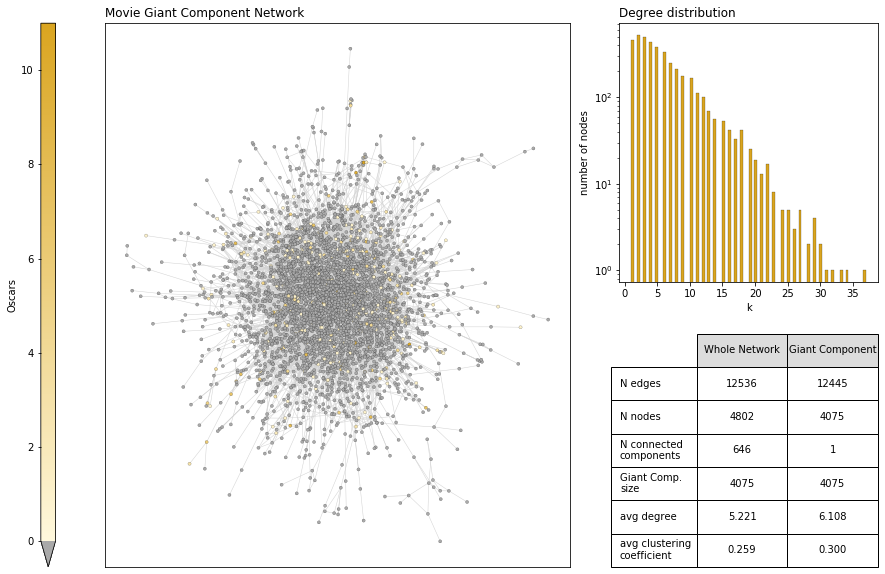

In [175]:
fig = plt.figure(figsize=(15,10))
gs = plt.GridSpec(2, 3, wspace=0.2, hspace=0.1, width_ratios=[0.02, 0.63, 0.35], height_ratios=[0.5, 0.5])
title_fs = 12

# Network visualization
atr = 'Oscars'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('node_cmap', ['cornsilk', 'goldenrod'])
cmap.set_under(color='darkgray')
ax_net = fig.add_subplot(gs[:,1])
nx.draw_networkx(the_graph, pos, ax=ax_net, \
                                with_labels=False, \
                                node_size=10, \
                                node_color =  list(nx.get_node_attributes(the_graph, atr).values()),\
                                vmin=0.01, cmap=cmap, \
                                alpha=1, \
                                linewidths=0.15, \
                                width=0.5, \
                                edge_color='lightgray')
ax_net.collections[0].set_edgecolor("#000000") 
ax_net.set_title('Movie Giant Component Network', loc='left', fontsize=title_fs)

# colorbar
color_ax = fig.add_subplot(gs[:,0])
nrm = matplotlib.colors.Normalize(vmin=nodes_attributes_df[atr].min(), vmax=nodes_attributes_df[atr].max())
fig.colorbar(matplotlib.cm.ScalarMappable(norm=nrm, cmap=cmap),\
                    cax=color_ax, extend='min')
color_ax.yaxis.set_ticks_position('left')
color_ax.yaxis.set_label_position('left')
color_ax.set_ylabel(atr)

# degree distribution 
ax_deg = fig.add_subplot(gs[0,2])
degrees = dict(the_graph.degree()).values()

ax_deg.hist(degrees, color='goldenrod', bins=80, linewidth=0.2, edgecolor='black', log=True)
ax_deg.set_title('Degree distribution', loc='left', fontsize=title_fs)
ax_deg.set_xlabel('k')
ax_deg.set_ylabel('number of nodes')

# table info
ax_table = fig.add_subplot(gs[1,2])
ax_table.set_axis_off()
table = ax_table.table(cellText=data, rowLabels=labels, cellLoc='center', \
                                     colColours=['gainsboro'] * len(labels), colLabels=['Whole Network', network_name], loc='center', \
                                     bbox=[0.3, 0, 0.7, 0.9])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1,1)

fig.savefig('Figures/network_summary.png', dpi=200, bbox_inches='tight')
plt.show()